In [59]:
import pandas as pd
import numpy as np
from scipy import signal, misc
from datetime import datetime, timedelta

import os
import json

In [60]:
#loading sensor information from Ascendo and Promethean DB
ascendo_data_parag=pd.read_csv("Ascendo_200011546604332_2019_09_21.csv")
ascendo_data_AK=pd.read_csv("AK_device_200011559554595.csv")
#ascendo_data_AK.drop(labels=['Unnamed: 0','id','room_temp1_mean','room_temp2_mean','dc_voltage_mean','updated_by','updated_on'], axis=1, inplace=True)
ascendo_data_AK=ascendo_data_AK.tail(24)

Promethean Data

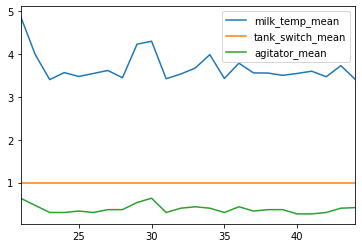

In [61]:
ascendo_data_AK[['milk_temp_mean','tank_switch_mean','agitator_mean']].plot()

Ascendo Data

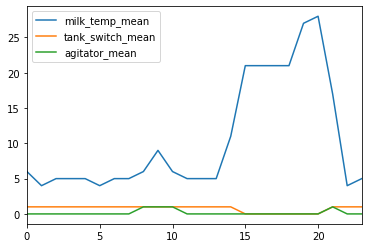

In [62]:
ascendo_data_parag[['milk_temp_mean','tank_switch_mean','agitator_mean']].plot()

# Detecting Milk Present

In [63]:
#life events    
def milk_present(milk_temp_mean):
    if int(milk_temp_mean) in range(12,20): #no product
        return 0
    elif milk_temp_mean in range(25, 35): #fresh product poured in
        return 2
    else:
        return 1
    
def create_life_events(new_df):
    
    new_df['milk_present']=new_df['milk_temp_mean'].apply(milk_present)

    tdf=pd.DataFrame(new_df,columns=['timestamp','milk_present','milk_temp_mean'])
    print(tdf)


life_events= create_life_events(ascendo_data_AK)   

                     timestamp  milk_present  milk_temp_mean
21  2019-12-30 22:00:00.000000             1        4.883333
22  2019-12-30 23:00:00.000000             1        3.993333
23  2019-12-31 00:00:00.000000             1        3.403333
24  2019-12-31 01:00:00.000000             1        3.566667
25  2019-12-31 02:00:00.000000             1        3.476667
26  2019-12-31 03:00:00.000000             1        3.546667
27  2019-12-31 04:00:00.000000             1        3.616667
28  2019-12-31 05:00:00.000000             1        3.446667
29  2019-12-31 06:00:00.000000             1        4.230000
30  2019-12-31 07:00:00.000000             1        4.300000
31  2019-12-31 08:00:00.000000             1        3.423333
32  2019-12-31 09:00:00.000000             1        3.533333
33  2019-12-31 10:00:00.000000             1        3.673333
34  2019-12-31 11:00:00.000000             1        3.986667
35  2019-12-31 12:00:00.000000             1        3.430000
36  2019-12-31 13:00:00.

# ERROR AT 2:00pm

The temperature went upto 11 but the milk present status is still 1 and only changes to 2 at 7:00pm when fresh milk was poured in (which holds true)

Creating another index for when milk is lifted

milk_present=3 indicates that milk was just lifted

In [64]:
import parameters
def milk_present(milk_temp_mean):
    if int(milk_temp_mean) in range(parameters.milk_not_present_low,parameters.milk_not_present_high): #no product!!!!! Made changes here
        return 0
    elif milk_temp_mean in range(parameters.fresh_product_low, parameters.fresh_product_high): #fresh product poured in
        return 2
    else:
        return 1
    
def create_life_events(new_df):
    
    new_df['milk_present']=new_df['milk_temp_mean'].apply(milk_present)
    new_val=[]
    list_milk=list(new_df['milk_present'])
    i=0
    for row in new_df.milk_present:
        #milk_present=3 indicating Fresh Milk
        if (new_df.milk_present.iloc[i-1]==1)&(row==0):
            new_val.append(3)
        #setting milk_present=1 for when it gets 10-25 range after fresh milk is poured
        elif (new_df.milk_present.iloc[i-1]==2)&(row==0):
            new_val.append(1)
        else:
            new_val.append(row)
        i=i+1
        
    new_df['milk_present']=new_val      
    tdf=pd.DataFrame(new_df,columns=['timestamp','milk_present','milk_temp_mean'])
    print(tdf)

   
life_events= create_life_events(ascendo_data_AK)

                     timestamp  milk_present  milk_temp_mean
21  2019-12-30 22:00:00.000000             1        4.883333
22  2019-12-30 23:00:00.000000             1        3.993333
23  2019-12-31 00:00:00.000000             1        3.403333
24  2019-12-31 01:00:00.000000             1        3.566667
25  2019-12-31 02:00:00.000000             1        3.476667
26  2019-12-31 03:00:00.000000             1        3.546667
27  2019-12-31 04:00:00.000000             1        3.616667
28  2019-12-31 05:00:00.000000             1        3.446667
29  2019-12-31 06:00:00.000000             1        4.230000
30  2019-12-31 07:00:00.000000             1        4.300000
31  2019-12-31 08:00:00.000000             1        3.423333
32  2019-12-31 09:00:00.000000             1        3.533333
33  2019-12-31 10:00:00.000000             1        3.673333
34  2019-12-31 11:00:00.000000             1        3.986667
35  2019-12-31 12:00:00.000000             1        3.430000
36  2019-12-31 13:00:00.

In [65]:
import parameters

def milk_edgecase(milk_temp_mean):

    if int(milk_temp_mean) in range(parameters.safe_milk_temp_low,parameters.safe_milk_temp_high): #safe temperature
        return 0
    elif milk_temp_mean >parameters.safe_milk_temp_high: #OVER upperbound - hotter product
        return 1
    else: #BELOW lowerbound - cold product
        return 2
    
def milk_present(milk_temp_mean):
    if int(milk_temp_mean) in range(parameters.milk_not_present_low,parameters.milk_not_present_high): #no product!!!!! Made changes here
        return 0
    elif milk_temp_mean in range(parameters.fresh_product_low, parameters.fresh_product_high): #fresh product poured in
        return 2
    else:
        return 1
    
def create_life_events(new_df):
    
    new_df['milk_present']=new_df['milk_temp_mean'].apply(milk_present)
    new_df['milk_temp_edgecase']=new_df['milk_temp_mean'].apply(milk_edgecase)
    new_val=[]
    list_milk=list(new_df['milk_present'])
    i=0
    for row in new_df.milk_present:
        #milk_present=3 indicating milk lift
        if (new_df.milk_present.iloc[i-1]==1)&(row==0):
            new_val.append(3)
        #setting milk_present=1 for when it gets 10-25 range after fresh milk is poured
        elif (new_df.milk_present.iloc[i-1]==2)&(row==0):
            new_val.append(1)
        else:
            new_val.append(row)
        i=i+1
        
    new_df['milk_present']=new_val      
    cooling_process=[]
    #tank switch on and discharge pump on
    for row in new_df.iterrows():

        if (row[1].tank_switch_mean!=0.0) &(row[1].discharge_pump_mean!=0.0):
            cooling_process.append(1) #cooling process in process
        else:
            cooling_process.append(0) 
    new_df['cooling']=cooling_process

    #creatn empty list to fill values into device_life_events table
    datetimelist=[]
    event_id=[]

    
    return new_df
   
life_events= create_life_events(ascendo_data_AK)  
new_df= create_life_events(ascendo_data_AK)

milk present value     description

    0                  no milk present
    1                  milk present
    2                  fresh milk
    3                  milk lift

# Incidents

# Incident 1: AC Voltage if turned OFF Often	

In [66]:
'''
Throughout the day, checking if AC is available when milk is present
milk_present==1 means
milk_temp_edgecase==0 means


'''
incident_1=[]
for t in new_df.iterrows():
    
        # milk_present==1  AND milk_temp_edgecase ==0 AND AC_voltage not in range
        if (t[1].milk_present ==1) & (t[1].milk_temp_edgecase==1) & (int(t[1].ac_voltage_mean) not in range(parameters.ac_voltage_low, parameters.ac_voltage_high)):  #incident 1
                    incident_1.append(1)
        else:
            incident_1.append(0)
new_df['incident_1']=incident_1        
new_df[['timestamp','milk_present','milk_temp_edgecase','ac_voltage_mean','incident_1']]

,timestamp,milk_present,milk_temp_edgecase,ac_voltage_mean,incident_1
21,2019-12-30 22:00:00.000000,1,0,226.833333,0
22,2019-12-30 23:00:00.000000,1,2,230.766667,0
23,2019-12-31 00:00:00.000000,1,2,234.366667,0
24,2019-12-31 01:00:00.000000,1,2,236.533333,0
25,2019-12-31 02:00:00.000000,1,2,237.166667,0
26,2019-12-31 03:00:00.000000,1,2,237.633333,0
27,2019-12-31 04:00:00.000000,1,2,235.433333,0
28,2019-12-31 05:00:00.000000,1,2,234.766667,0
29,2019-12-31 06:00:00.000000,1,0,229.133333,0
30,2019-12-31 07:00:00.000000,1,0,219.400000,0


In [67]:
#checking a hypotheical day
ac_voltage=[222,222,0,0,0,0,222,0,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222]
new_df['ac_voltage']=ac_voltage
incident_1=[]
for t in new_df.iterrows():
        # milk_present==1  AND milk_temp_edgecase ==0 AND AC_voltage not in range
        if (t[1].milk_present ==1) & (t[1].milk_temp_edgecase==0) & (int(t[1].ac_voltage) not in range(parameters.ac_voltage_low, parameters.ac_voltage_high)):  #incident 1
                incident_1.append(1)    
                #print('Incident 1: No AC when milk is present @',t[1][15])                 
        else:
            incident_1.append(0)

new_df['incident_1']=incident_1        
new_df[['timestamp','milk_present','milk_temp_edgecase','ac_voltage','incident_1']]

,timestamp,milk_present,milk_temp_edgecase,ac_voltage,incident_1
21,2019-12-30 22:00:00.000000,1,0,222,0
22,2019-12-30 23:00:00.000000,1,2,222,0
23,2019-12-31 00:00:00.000000,1,2,0,0
24,2019-12-31 01:00:00.000000,1,2,0,0
25,2019-12-31 02:00:00.000000,1,2,0,0
26,2019-12-31 03:00:00.000000,1,2,0,0
27,2019-12-31 04:00:00.000000,1,2,222,0
28,2019-12-31 05:00:00.000000,1,2,0,0
29,2019-12-31 06:00:00.000000,1,0,222,0
30,2019-12-31 07:00:00.000000,1,0,222,0


# Incident 2: Discharge pump going OFF

In [68]:
'''
milk is present and over 6, but Discharge pump is OFF
'''
incident_2=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1) & (t[1].milk_temp_mean>parameters.safe_milk_temp_high) & (t[1].discharge_pump_mean==0):  #incident 2
                    incident_2.append(1)
    else:
        incident_2.append(0)
new_df['incident_2']=incident_2    
new_df[['timestamp','milk_present','milk_temp_mean','discharge_pump_mean','incident_2']]    


,timestamp,milk_present,milk_temp_mean,discharge_pump_mean,incident_2
21,2019-12-30 22:00:00.000000,1,4.883333,1.0,0
22,2019-12-30 23:00:00.000000,1,3.993333,1.0,0
23,2019-12-31 00:00:00.000000,1,3.403333,1.0,0
24,2019-12-31 01:00:00.000000,1,3.566667,1.0,0
25,2019-12-31 02:00:00.000000,1,3.476667,1.0,0
26,2019-12-31 03:00:00.000000,1,3.546667,1.0,0
27,2019-12-31 04:00:00.000000,1,3.616667,1.0,0
28,2019-12-31 05:00:00.000000,1,3.446667,1.0,0
29,2019-12-31 06:00:00.000000,1,4.230000,1.0,0
30,2019-12-31 07:00:00.000000,1,4.300000,1.0,0


In [69]:
#hypotetical day
discharge_pump=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

new_df['discharge_pump']=discharge_pump
incident_2=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1) & (t[1].milk_temp_mean>parameters.safe_milk_temp_high) & (t[1].discharge_pump==0):  #incident 2
                    incident_2.append(1)
    else:
        incident_2.append(0)
new_df['incident_2']=incident_2    
new_df[['timestamp','milk_present','milk_temp_mean','discharge_pump','incident_2']] 

,timestamp,milk_present,milk_temp_mean,discharge_pump,incident_2
21,2019-12-30 22:00:00.000000,1,4.883333,0,0
22,2019-12-30 23:00:00.000000,1,3.993333,0,0
23,2019-12-31 00:00:00.000000,1,3.403333,0,0
24,2019-12-31 01:00:00.000000,1,3.566667,0,0
25,2019-12-31 02:00:00.000000,1,3.476667,0,0
26,2019-12-31 03:00:00.000000,1,3.546667,0,0
27,2019-12-31 04:00:00.000000,1,3.616667,0,0
28,2019-12-31 05:00:00.000000,1,3.446667,0,0
29,2019-12-31 06:00:00.000000,1,4.230000,0,0
30,2019-12-31 07:00:00.000000,1,4.300000,0,0


# Incident 3: Tank Switch being turned OFF	

In [70]:
'''
Milk present but Tank Switch OFF 
'''
incident_3=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1)  & (t[1].tank_switch_mean==0):  #incident 3
        incident_3.append(1)
    else:
        incident_3.append(0)
new_df['incident_3']=incident_3    
new_df[['timestamp','milk_present','milk_temp_mean','tank_switch_mean','incident_3']]    


,timestamp,milk_present,milk_temp_mean,tank_switch_mean,incident_3
21,2019-12-30 22:00:00.000000,1,4.883333,1.0,0
22,2019-12-30 23:00:00.000000,1,3.993333,1.0,0
23,2019-12-31 00:00:00.000000,1,3.403333,1.0,0
24,2019-12-31 01:00:00.000000,1,3.566667,1.0,0
25,2019-12-31 02:00:00.000000,1,3.476667,1.0,0
26,2019-12-31 03:00:00.000000,1,3.546667,1.0,0
27,2019-12-31 04:00:00.000000,1,3.616667,1.0,0
28,2019-12-31 05:00:00.000000,1,3.446667,1.0,0
29,2019-12-31 06:00:00.000000,1,4.230000,1.0,0
30,2019-12-31 07:00:00.000000,1,4.300000,1.0,0


In [71]:
#hypothetical day
tank_switch=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

new_df['tank_switch']=tank_switch
incident_3=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1)  & (t[1].tank_switch==0):  #incident 3
        incident_3.append(1)
    else:
        incident_3.append(0)
new_df['incident_3']=incident_3    
new_df[['timestamp','milk_present','tank_switch','incident_3']]    

,timestamp,milk_present,tank_switch,incident_3
21,2019-12-30 22:00:00.000000,1,0,1
22,2019-12-30 23:00:00.000000,1,0,1
23,2019-12-31 00:00:00.000000,1,0,1
24,2019-12-31 01:00:00.000000,1,0,1
25,2019-12-31 02:00:00.000000,1,0,1
26,2019-12-31 03:00:00.000000,1,0,1
27,2019-12-31 04:00:00.000000,1,0,1
28,2019-12-31 05:00:00.000000,1,0,1
29,2019-12-31 06:00:00.000000,1,0,1
30,2019-12-31 07:00:00.000000,1,0,1


# Incident 4: Pattern of not enough cooling	

In [72]:
'''
Milk present but cooling hasnt began
Cooling is defined as time when Tank Switch and Discharge Pump is ON
'''
incident_4=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1)  & (t[1].tank_switch_mean==0) & (t[1].discharge_pump_mean==0):  #incident 4
        incident_4.append(1)
    else:
        incident_4.append(0)
new_df['incident_4']=incident_4    
new_df[['timestamp','milk_present','milk_temp_mean','tank_switch_mean','discharge_pump_mean','incident_4']]    

,timestamp,milk_present,milk_temp_mean,tank_switch_mean,discharge_pump_mean,incident_4
21,2019-12-30 22:00:00.000000,1,4.883333,1.0,1.0,0
22,2019-12-30 23:00:00.000000,1,3.993333,1.0,1.0,0
23,2019-12-31 00:00:00.000000,1,3.403333,1.0,1.0,0
24,2019-12-31 01:00:00.000000,1,3.566667,1.0,1.0,0
25,2019-12-31 02:00:00.000000,1,3.476667,1.0,1.0,0
26,2019-12-31 03:00:00.000000,1,3.546667,1.0,1.0,0
27,2019-12-31 04:00:00.000000,1,3.616667,1.0,1.0,0
28,2019-12-31 05:00:00.000000,1,3.446667,1.0,1.0,0
29,2019-12-31 06:00:00.000000,1,4.230000,1.0,1.0,0
30,2019-12-31 07:00:00.000000,1,4.300000,1.0,1.0,0


In [73]:
#hypothetical day

discharge_pump=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
new_df['discharge_pump']=discharge_pump
tank_switch=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
new_df['tank_switch']=tank_switch
incident_4=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1)  & (t[1].tank_switch==0) & (t[1].discharge_pump==0):  #incident 4
        incident_4.append(1)
    else:
        incident_4.append(0)
new_df['incident_4']=incident_4    
new_df[['timestamp','milk_present','tank_switch','discharge_pump','incident_4']]

,timestamp,milk_present,tank_switch,discharge_pump,incident_4
21,2019-12-30 22:00:00.000000,1,0,0,1
22,2019-12-30 23:00:00.000000,1,0,0,1
23,2019-12-31 00:00:00.000000,1,0,0,1
24,2019-12-31 01:00:00.000000,1,0,0,1
25,2019-12-31 02:00:00.000000,1,0,0,1
26,2019-12-31 03:00:00.000000,1,0,0,1
27,2019-12-31 04:00:00.000000,1,0,0,1
28,2019-12-31 05:00:00.000000,1,0,0,1
29,2019-12-31 06:00:00.000000,1,0,0,1
30,2019-12-31 07:00:00.000000,1,0,0,1


# Incident 5: Pattern of Tank switch being ON when not required	

In [74]:
'''
No Milk but Tank Switch is ON
'''
incident_5=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==0)  & (t[1].tank_switch_mean==1) :  #incident 5
        incident_5.append(1)
    else:
        incident_5.append(0)
new_df['incident_5']=incident_5    
new_df[['timestamp','milk_present','milk_temp_mean','tank_switch_mean','incident_5']]    

,timestamp,milk_present,milk_temp_mean,tank_switch_mean,incident_5
21,2019-12-30 22:00:00.000000,1,4.883333,1.0,0
22,2019-12-30 23:00:00.000000,1,3.993333,1.0,0
23,2019-12-31 00:00:00.000000,1,3.403333,1.0,0
24,2019-12-31 01:00:00.000000,1,3.566667,1.0,0
25,2019-12-31 02:00:00.000000,1,3.476667,1.0,0
26,2019-12-31 03:00:00.000000,1,3.546667,1.0,0
27,2019-12-31 04:00:00.000000,1,3.616667,1.0,0
28,2019-12-31 05:00:00.000000,1,3.446667,1.0,0
29,2019-12-31 06:00:00.000000,1,4.230000,1.0,0
30,2019-12-31 07:00:00.000000,1,4.300000,1.0,0


In [75]:
#hypothetical day

tank_switch=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
new_df['tank_switch']=tank_switch
incident_5=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==1)  & (t[1].tank_switch==0):  #incident 5
        incident_5.append(1)
    else:
        incident_5.append(0)
new_df['incident_5']=incident_5    
new_df[['timestamp','milk_present','tank_switch','incident_5']]

,timestamp,milk_present,tank_switch,incident_5
21,2019-12-30 22:00:00.000000,1,0,1
22,2019-12-30 23:00:00.000000,1,0,1
23,2019-12-31 00:00:00.000000,1,0,1
24,2019-12-31 01:00:00.000000,1,0,1
25,2019-12-31 02:00:00.000000,1,0,1
26,2019-12-31 03:00:00.000000,1,0,1
27,2019-12-31 04:00:00.000000,1,0,1
28,2019-12-31 05:00:00.000000,1,0,1
29,2019-12-31 06:00:00.000000,1,0,1
30,2019-12-31 07:00:00.000000,1,0,1


# Incident 6:  No Milk but Tank Switch is ON for more than 3 hours

In [76]:
'''
No Milk but Tank Switch is ON for more than 3 hours
'''
#hypothetical day 
count_6=0
i=1
tank_switch=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
new_df['tank_switch']=tank_switch
incident_6=[]
for t in new_df.iterrows():
    if (t[1].milk_present ==0)  & (t[1].tank_switch==1) :  #incident 6
        incident_6.append(1)
    else:
        incident_6.append(0)
    i=i+1
   
new_val=[]
i=1
milk_present=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0]
new_df['milk_present']=milk_present
for t in new_df.iterrows():
    if (t[1].milk_present ==0)  & (t[1].tank_switch==1) :  #incident 6    
        count_6=count_6+1
        if (count_6>3)&(incident_6[i-1]==1):
            new_val.append(1)
        else:
            new_val.append(0)
    else:
            new_val.append(0) 
            count_6=0
    i=i+1  
new_df['incident_6']=new_val 
new_df[['timestamp','milk_present','tank_switch','incident_6']]    

,timestamp,milk_present,tank_switch,incident_6
21,2019-12-30 22:00:00.000000,1,1,0
22,2019-12-30 23:00:00.000000,1,1,0
23,2019-12-31 00:00:00.000000,1,1,0
24,2019-12-31 01:00:00.000000,1,1,0
25,2019-12-31 02:00:00.000000,1,1,0
26,2019-12-31 03:00:00.000000,1,1,0
27,2019-12-31 04:00:00.000000,1,1,0
28,2019-12-31 05:00:00.000000,1,1,0
29,2019-12-31 06:00:00.000000,1,1,0
30,2019-12-31 07:00:00.000000,1,1,0


# Incident 10: Tank switch ON during milk lift

In [77]:
def milk_present(milk_temp_mean):
    if int(milk_temp_mean) in range(parameters.milk_not_present_low,parameters.milk_not_present_high): #no product!!!!! Made changes here
        return 0
    elif milk_temp_mean in range(parameters.fresh_product_low, parameters.fresh_product_high): #fresh product poured in
        return 2
    else:
        return 1
    
def create_life_events(new_df):
    
    new_df['milk_present']=new_df['milk_temp_mean'].apply(milk_present)
    new_val=[]
    list_milk=list(new_df['milk_present'])
    i=0
    for row in new_df.milk_present:
        #milk_present=3 indicating Fresh Milk
        if (new_df.milk_present.iloc[i-1]==1)&(row==0):
            new_val.append(3)
        #setting milk_present=1 for when it gets 10-25 range after fresh milk is poured
        elif (new_df.milk_present.iloc[i-1]==2)&(row==0):
            new_val.append(1)
        else:
            new_val.append(row)
        i=i+1
        
    new_df['milk_present']=new_val      
    
    return new_df


new_df= create_life_events(ascendo_data_AK)
incident_10=[]
for row in new_df.iterrows():
    if (row[1].milk_present==3)&(row[1].tank_switch_mean==1):
        incident_10.append(1)
    else: 
        incident_10.append(0)
        
new_df['incident_10']=incident_10
new_df[['milk_temp_mean','milk_present','tank_switch_mean','incident_10','timestamp']]

,milk_temp_mean,milk_present,tank_switch_mean,incident_10,timestamp
21,4.883333,1,1.0,0,2019-12-30 22:00:00.000000
22,3.993333,1,1.0,0,2019-12-30 23:00:00.000000
23,3.403333,1,1.0,0,2019-12-31 00:00:00.000000
24,3.566667,1,1.0,0,2019-12-31 01:00:00.000000
25,3.476667,1,1.0,0,2019-12-31 02:00:00.000000
26,3.546667,1,1.0,0,2019-12-31 03:00:00.000000
27,3.616667,1,1.0,0,2019-12-31 04:00:00.000000
28,3.446667,1,1.0,0,2019-12-31 05:00:00.000000
29,4.230000,1,1.0,0,2019-12-31 06:00:00.000000
30,4.300000,1,1.0,0,2019-12-31 07:00:00.000000


In [ ]:
def give_hour(t):
            day,un,hour=str(t).split(" ")
            return hour
    
def split_month(t):
    year,month,rest=str(t).split("-")
    return month

def split_day(t):
            day,hour=str(t).split(" ")
            return day
def split_year(t):
    year,month,rest=str(t).split("-")
    return year

def combine_mins(t):
            day,hour=str(t).split(" ")
            hour,mins,seconds=str(hour).split(":")
            return hour
        
def split_date(data):
    data['date']=data.timestamp.apply(split_day)
    data['year']=data.timestamp.apply(split_year)
    data['month']=data.timestamp.apply(split_month)
    data['hour']=data.timestamp.apply(combine_mins)
    return data